# 5. Analysis

Time for some machine learning!

In [1]:
# set up some dependencies
import json, time, random, csv
import numpy as np
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import descartes # for plotting with geopanadas

In [2]:
# set up path to app credentials - see exploration/README.md
%env GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json

# set up bigquery client
from google.cloud import bigquery
bq = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json


In [3]:
# grab valid years and check BigQuery connection
resp = bq.query('''
    SELECT DISTINCT do_date AS year
    FROM `eosc410-project.data.acs_cbsa_20*`
    ORDER BY do_date ASC
''')
years = [row["year"] for row in resp]

In [4]:
'''
Gets the GeoID from the combined ID
'''
def combined_id_to_geoid(combined_id: str) -> str:
    parts = combined_id.split('.')
    if len(parts) < 1:
        return ''
    return parts[0]
def combined_id_to_epa_param(combined_id: str) -> str:
    parts = combined_id.split('.')
    if len(parts) < 3:
        return ''
    return parts[len(parts)-1]

In [5]:
# load up aggregated data - refer to _data/acs/README.md and _data/epa/README.md
acs_ts_flat = pd.read_csv('../docs/_data/acs/timeseries_flat.csv')
acs_ts_vert = pd.read_csv('../docs/_data/acs/timeseries_vert.csv')
acs_ts_vert_alt = pd.read_csv('../docs/_data/acs/timeseries_vert_alt.csv',index_col=0)
epa_ts_flat = pd.read_csv('../docs/_data/epa/timeseries_flat.csv')
epa_ts_vert = pd.read_csv('../docs/_data/epa/timeseries_vert.csv')

# take a peak at what's up
print('==== ACS Aggregates\n')
print(acs_ts_vert_alt.dtypes, '\n')
# print('==== EPA Aggregates\n')
# print(epa_ts_flat.dtypes, '\n')
# print(epa_ts_vert.dtypes, '\n')

==== ACS Aggregates

geoid                                        int64
2007.commute_10_29_mins                    float64
2007.commute_30_59_mins                    float64
2007.commute_over_60_mins                  float64
2007.commute_under_10_mins                 float64
                                            ...   
2018.rent_over_50_percent                  float64
2018.rent_under_25_percent                 float64
2018.some_college_and_associates_degree    float64
2018.total_pop                             float64
2018.walked_to_work                        float64
Length: 337, dtype: object 



In [6]:
resp = bq.query('''
SELECT DISTINCT(geo_id) AS geoid
FROM `eosc410-project.data.acs_cbsa_20*` # multi-table query
''')
geoids = [row["geoid"] for row in resp]
len(geoids)

557

In [7]:
# find epa value for corresponding geoids
epa_aggs = pd.DataFrame(data={'geoid': geoids})
for index, row in epa_aggs.iterrows():
    geoid = row['geoid']
    rows_with_geoid = epa_ts_vert[epa_ts_vert['combined_id'].str.startswith("%s." % geoid)]
    for param in ['88502', '68105']:
        # columns: [combined_id, year.stdev, year.mean, ...]
        # rows: combined_id with this geoid, param
        rows_with_param = rows_with_geoid[rows_with_geoid['combined_id'].str.endswith(".%s" % param)]
        rows_with_param['geoid'] = [geoid for i in range(len(rows_with_param))]

        # want:
        # columns: [geoid, year.mean, year.stdev]
        def rename_column(col):
            if col.startswith('2'):
                return '%s.%s' % (col, param)
            return col
        row_data = rows_with_param.dropna().groupby(['geoid']).mean().rename(columns=lambda col: rename_column(col))
        if len(row_data) > 0:
            for (col, data) in row_data.iteritems():
                epa_aggs.loc[index, col] = data.iloc[0]

print('\n===\nresults')
epa_aggs.head()

    # rows_with_param_combined= rows_with_param.groupby('combined_id').agg(np.mean) #group geoid and get mean of each column
    # print('\n%d measurements of parameter %s for geoid %s' % (len(rows_with_param), param, geoid))
    # print(rows_with_param[['2007.mean', '2007.stdev']].head())


===
results


,geoid,Unnamed: 0,2007.mean.68105,2007.stdev.68105,2008.mean.68105,2008.stdev.68105,2009.mean.68105,2009.stdev.68105,2010.mean.68105,2010.stdev.68105,...,2014.mean.88502,2014.stdev.88502,2015.mean.88502,2015.stdev.88502,2016.mean.88502,2016.stdev.88502,2017.mean.88502,2017.stdev.88502,2018.mean.88502,2018.stdev.88502
0,18880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
'''
Generate time series for given geoid
'''
def get_timeseries_for_geoid(geoid):
    epa_row = epa_aggs[epa_aggs.geoid==geoid]
    epa = pd.DataFrame(data={'year': years})
    for (col, vals) in epa_row.iteritems():
        if col.startswith('2'):
            year = col.split('.')[0]
            measurement = '%s.%s' % (col.split('.')[1], col.split('.')[2]) # 3-part combined id
            feature = '%s.epa.%s' % (geoid, measurement)
            row_index = epa.index[epa['year'] == year].tolist()[0] # should have single match
            epa.loc[row_index, feature] = vals.iloc[0] # should be single row

    acs = acs_ts_flat[['year'] + [col for col in acs_ts_flat if col.startswith(geoid)]]
    acs['year'] = acs['year'].astype(str)
    print(epa.head())

    geoid_df = pd.merge(acs, epa, on=['year'])
    geoid_df = geoid_df.loc[:, ~geoid_df.columns.str.contains('^Unnamed')]
    return geoid_df


In [9]:
df_41860 = get_timeseries_for_geoid('41860')
df_41860
df_41860.columns.values.tolist()

year  41860.epa.mean.68105  41860.epa.stdev.68105  41860.epa.mean.88502  \
0  2007                   NaN                    NaN              5.341525   
1  2008                   NaN                    NaN              6.110345   
2  2009                   NaN                    NaN              5.256250   
3  2010                   NaN                    NaN              5.086087   
4  2011                   NaN                    NaN              5.492000   

   41860.epa.stdev.88502  
0               3.711114  
1               3.890733  
2               3.379103  
3               3.431610  
4               3.956268  


['year',
 '41860.acs.commute_10_29_mins',
 '41860.acs.commute_30_59_mins',
 '41860.acs.commute_over_60_mins',
 '41860.acs.commute_under_10_mins',
 '41860.acs.commuters_by_car_truck_van',
 '41860.acs.commuters_by_public_transportation',
 '41860.acs.dwellings_20_to_49_units',
 '41860.acs.dwellings_50_or_more_units',
 '41860.acs.dwellings_5_to_19_units',
 '41860.acs.dwellings_under_4_units',
 '41860.acs.family_households',
 '41860.acs.gini_index',
 '41860.acs.graduate_professional_degree',
 '41860.acs.high_school_including_ged',
 '41860.acs.housing_units',
 '41860.acs.income_per_capita',
 '41860.acs.median_age',
 '41860.acs.median_rent',
 '41860.acs.median_structure_age',
 '41860.acs.nonfamily_households',
 '41860.acs.occupied_housing_units',
 '41860.acs.poverty',
 '41860.acs.rent_25_to_50_percent',
 '41860.acs.rent_over_50_percent',
 '41860.acs.rent_under_25_percent',
 '41860.acs.some_college_and_associates_degree',
 '41860.acs.total_pop',
 '41860.acs.walked_to_work',
 '41860.epa.mean.68

<Figure size 5760x5760 with 0 Axes>

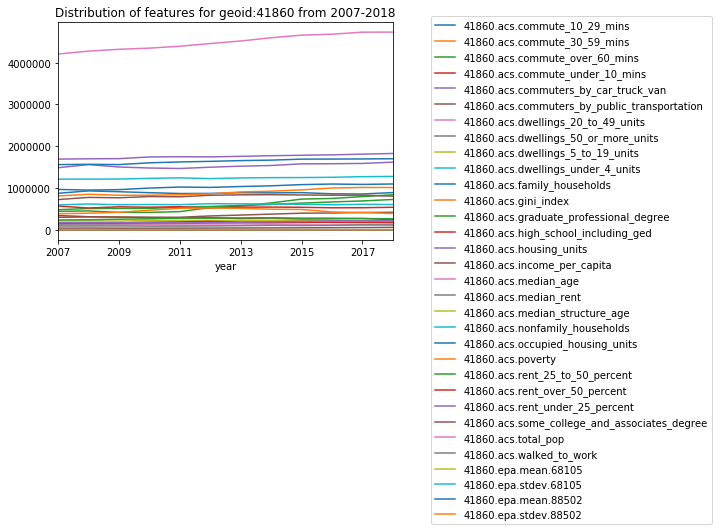

In [56]:
plt.figure(figsize=(80,80))
df_41860.set_index('year').plot()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Distribution of features for geoid:41860 from 2007-2018')
plt.savefig('../exploration/figs/analysis/41860_distribution_of_features.png')

In [11]:
# first, perform PCA to find spatial modes and understand relation between features 

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# standardize data
features = ['41860.acs.commute_10_29_mins',
 '41860.acs.commute_30_59_mins',
 '41860.acs.commute_over_60_mins',
 '41860.acs.commute_under_10_mins',
 '41860.acs.commuters_by_car_truck_van',
 '41860.acs.commuters_by_public_transportation',
 '41860.acs.dwellings_20_to_49_units',
 '41860.acs.dwellings_50_or_more_units',
 '41860.acs.dwellings_5_to_19_units',
 '41860.acs.dwellings_under_4_units',
 '41860.acs.family_households',
 '41860.acs.gini_index',
 '41860.acs.graduate_professional_degree',
 '41860.acs.high_school_including_ged',
 '41860.acs.housing_units',
 '41860.acs.income_per_capita',
 '41860.acs.median_age',
 '41860.acs.median_rent',
 '41860.acs.median_structure_age',
 '41860.acs.nonfamily_households',
 '41860.acs.occupied_housing_units',
 '41860.acs.poverty',
 '41860.acs.rent_25_to_50_percent',
 '41860.acs.rent_over_50_percent',
 '41860.acs.rent_under_25_percent',
 '41860.acs.some_college_and_associates_degree',
 '41860.acs.total_pop',
 '41860.acs.walked_to_work']
# Separating out the features
x = df_41860.loc[:, features].values
# Separating out the target
y = df_41860.loc[:,['41860.epa.mean.88502','41860.epa.mean.68105']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [16]:
# pca
n_modes = np.min(np.shape(x))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(x)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

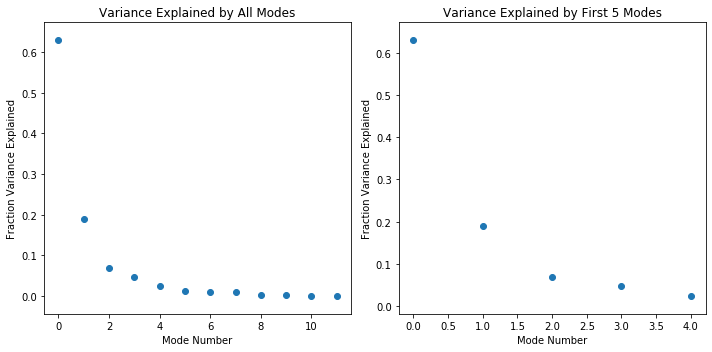

In [57]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 5
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()
plt.savefig('../exploration/figs/analysis/41860_pca.png')
plt.show()

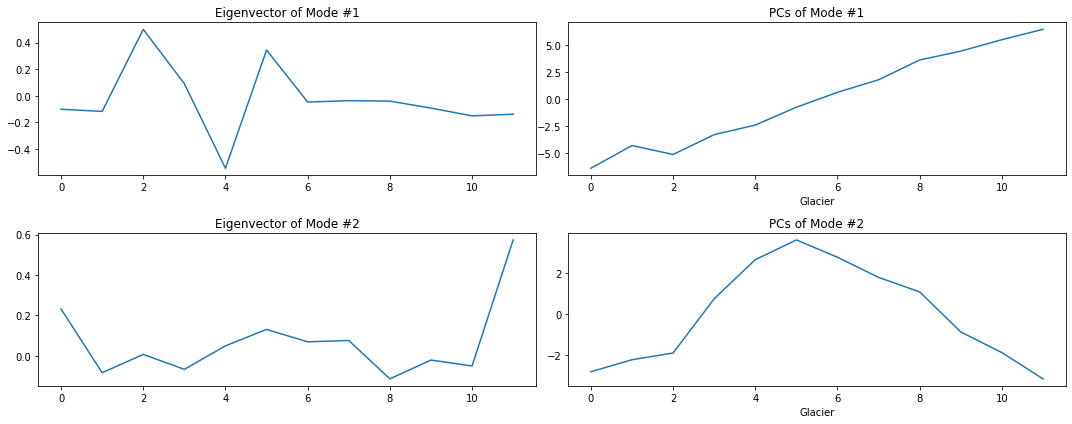

In [61]:
n = 2

plt.figure(figsize=(15,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.plot(eigvecs[:,kk])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Glacier')

    plt.savefig('../exploration/figs/analysis/41860_PCs_v_Eigvecs.png')
    plt.tight_layout()



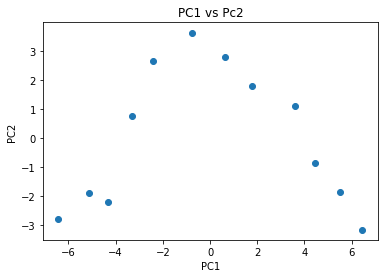

In [62]:
plt.figure()
plt.scatter(PCs[:,0],PCs[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs Pc2')
plt.savefig('../exploration/figs/analysis/41860_PC1_v_PC2.png')
# Principal components tell you the direction in which your data is more spread out. 
#Therefore, PC2 will tell you the largest amount of variation that has not been captured by PC1. 
#And the same applies for PC3 with respect to PC2, and so on. 
#This is the reason why one usually looks to the first PCs in a PCA.

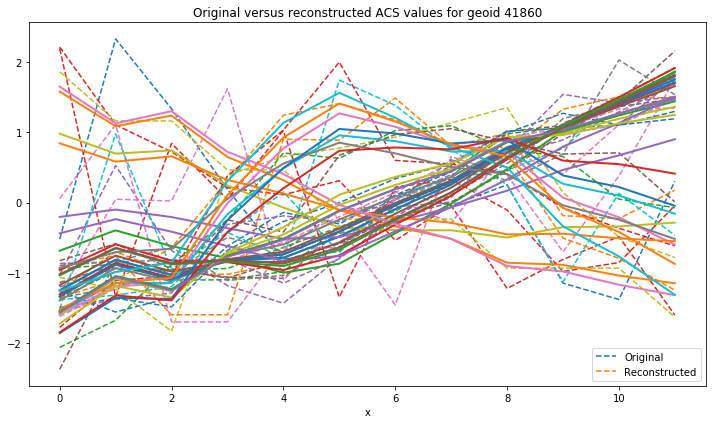

In [63]:
#reconstruct SST and SLP, using first two modes for each dataset

n_modes = 2
numObs = np.shape(x)[0]
xdata_rec = np.empty_like(x)

for kk in range(numObs): #for each month
    this_xdata_rec = np.zeros_like(x[0])
    for mode in range(n_modes):
        this_xdata_rec += eigvecs[mode,:]*PCs[kk,mode]    
    xdata_rec[kk,:] = this_xdata_rec

plt.figure(figsize=(10,6))
plt.plot(x,linestyle = '--')
plt.plot(xdata_rec, linewidth=2 )
plt.xlabel('x')
plt.legend(['Original','Reconstructed'])  
plt.title('Original versus reconstructed ACS values for geoid 41860')
plt.savefig('../exploration/figs/analysis/41860_reconstructed_x_data.png')

plt.tight_layout()

    

In [64]:
n_modes = 2
numObs = np.shape(y)[0]
ydata_rec = np.empty_like(y)

for kk in range(numObs): #for each month
    this_ydata_rec = np.zeros_like(y[0])
    for mode in range(n_modes):
        this_ydata_rec += eigvecs[mode,:]*PCs[kk,mode]    
    ydata_rec[kk,:] = this_ydata_rec

plt.figure(figsize=(10,6))
plt.plot(y,linestyle = '--')
plt.plot(ydata_rec, linewidth=2 )
plt.xlabel('x')
plt.legend(['Original','Reconstructed'])  
plt.title('Original versus reconstructed ACS values for geoid 41860')
# plt.savefig('../exploration/figs/analysis/41860_reconstructed_x_data.png')

plt.tight_layout()

ValueError: operands could not be broadcast together with shapes (2,) (28,) (2,) 

In [ ]:
n_modes_SLP = 2
numObs = np.shape(pca_input_SLP)[0]
ydata_rec = np.empty_like(pca_input_SLP)
for kk in range(numObs): #for each month
    this_ydata_rec = np.zeros_like(ydata[0])
    for mode in range(n_modes_SST):
        this_ydata_rec += eigvecs_SLP[mode,:]*PCs_SLP[kk,mode]    
    ydata_rec[kk,:] = this_ydata_rec

In [55]:
#do CCA
n_modes = 2 #modes to keep
cca = CCA(n_components=n_modes,max_iter = 10000)

U = cca.fit_transform(xdata_rec)
A = cca.x_weights_
B = cca.y_weights_
F = np.cov(x.T)@A
r = [np.corrcoef(U[:,ii]) for ii in range(n_modes)]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [65]:
resp = bq.query('''
    SELECT DISTINCT(geo_id) AS geoid
    FROM `eosc410-project.data.acs_cbsa_20*`
''')
geoids = [row["geoid"] for row in resp]
print(geoids)

['37820', '25620', '24780', '48020', '44600', '14580', '44420', '19140', '46660', '11500', '43060', '31460', '49020', '48060', '29420', '32940', '45500', '30140', '48980', '36980', '43740', '31020', '36300', '14100', '11980', '19060', '16020', '19260', '16220', '19300', '46180', '23580', '27860', '19180', '41140', '20620', '25220', '11780', '24020', '19460', '16940', '41580', '31900', '37460', '10700', '47020', '30620', '25740', '49780', '29700', '39980', '32100', '27620', '44220', '20700', '46220', '47700', '30340', '13980', '31940', '38940', '37620', '44980', '10380', '24140', '36660', '47580', '11300', '21060', '33140', '33220', '10880', '34100', '22840', '40580', '11020', '35260', '34820', '23460', '30500', '40780', '48740', '15260', '35100', '11340', '12980', '21460', '30300', '27900', '25860', '33500', '22140', '37020', '41660', '46380', '14140', '46300', '37140', '27460', '36220', '20220', '26740', '48660', '33260', '13020', '36140', '39140', '40660', '44380', '45640', '13180', 

In [71]:
import math
def split_dataset():
    train = random.sample(geoids, math.floor(len(geoids) * 0.75))
    test = random.sample(geoids, math.floor(len(geoids) * 0.25))
    return (train, test)

In [74]:
print('training samples', len(split_dataset()[0]))

417


In [ ]:
# try 10 different splits
for i in range(0, 10):
    splt = split_dataset()
    models = [] # train a bunch of models
    for geoid in splt[0]:
        # training geoids

    # reconstruct test samples using each model, take mode/median/something
    for geoid in split[1]:
        # testing geoids
